In [2]:
# if connecting from same gdrive, mounting it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# if connecting from different gdrive than the account running the notebook
# !sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !sudo apt-get update -qq 2>&1 > /dev/null
# !sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
# !google-drive-ocamlfuse

# if error is recieved, click on the link and authenticate

In [ ]:
# # only run if connecting from different gdrive 
# !sudo apt-get install -qq w3m # to act as web browser 
# !xdg-settings set default-web-browser w3m.desktop # to set default browser
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

In [119]:
! pip install wandb

In [120]:
import wandb
wandb.login()
#ec0fa02abb6680e2e41f9e94ffb3c3a636ca9007

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [61]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy
from tqdm import tqdm

import pickle
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator 

In [111]:
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes/'
width=256
height=256
depth=3
batch_size = 64
num_classes =23

In [122]:
train_config = {"EPOCHS" : 15,
"INIT_LR" : 1e-3,
"BS" : 32,
"default_image_size" : tuple((256, 256)),
"image_size" : 0,
"directory_root" : '/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes/data',
"width":256,
"height":256,
"depth":3,
"batch_size" : 64,
"num_classes" :23}

In [123]:
run = wandb.init(project="shuffleNet3", config=train_config)

wandb: Currently logged in as: prvns1997 (p1). Use `wandb login --relogin` to force relogin


In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [104]:
data_path = '/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes/data/'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [105]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}
train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.3, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.7, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [106]:
print(len(dataset['train']))
print(len(dataset['valid']))
print(len(dataset['test']))

37053
4764
11116


In [107]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [108]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [109]:
device = get_default_device()
device

device(type='cuda')

In [112]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=False,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  train/valid/test : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  train/valid/test : 579 / 75 / 174


In [ ]:
#class distribution test

count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)

v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fae6e2c34c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.9/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


IndexError: ignored

In [ ]:
# imgtest = None
# for images, labels in dataloaders['train']:  
#     print(images)
#     print(labels)
#     imgtest = images[3]
#     print(imgtest.shape)
#     break

# imgtest = imgtest.numpy()
# imgtest = np.moveaxis(imgtest, 0, -1)
# imshow(imgtest)

In [113]:
# modeling
from torchvision import models
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.shufflenet_v2_x2_0(weights = None,num_classes=num_classes,progress=True)
        
        for parameter in self.model.parameters():
            parameter.require_grad = False
        
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, image):
        output = self.model(image)
        return output

In [114]:
dataloaders['train'] = DeviceDataLoader(dataloaders['train'], device)
dataloaders['valid'] = DeviceDataLoader(dataloaders['valid'], device)
dataloaders['test'] = DeviceDataLoader(dataloaders['test'], device)

In [115]:
model = to_device(PlantDiseaseModel(classes=num_classes), device) 

optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()
model


PlantDiseaseModel(
  (model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(122, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 122, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

In [ ]:
# # defining the model and moving it to the GPU
# model = to_device(PlantDiseaseModel(len(train.classes)), device) 
# model

In [117]:
%pwd


'/content/drive/MyDrive/AI Project/Dataset1/New Plant Diseases Dataset(Augmented)_ 23 classes'

In [124]:
num_epochs = 15
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0
dev = device
since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in tqdm(enumerate(dataloaders['train'])):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in tqdm(enumerate(dataloaders['valid'])):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    wandb.log({'epoch':(epoch+1)/num_epochs,'training_loss': trn_loss/batch_num['train'],'validation_loss': val_loss/batch_num['valid']})
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet3/best_model.pt')
print("model saved")

579it [00:37, 15.51it/s]
75it [00:04, 15.59it/s]


epoch: 1/15 | trn loss: 3.1265 | val loss: 3.1231 | 0m 42s elapsed
best model updated-epoch: 1 | val_accuracy: 5.3240


579it [00:37, 15.53it/s]
75it [00:04, 15.61it/s]


epoch: 2/15 | trn loss: 3.1207 | val loss: 3.1159 | 1m 24s elapsed
best model updated-epoch: 2 | val_accuracy: 10.1640


579it [00:37, 15.54it/s]
75it [00:05, 15.00it/s]


epoch: 3/15 | trn loss: 3.1110 | val loss: 3.1057 | 2m 7s elapsed


579it [00:37, 15.54it/s]
75it [00:04, 15.12it/s]


epoch: 4/15 | trn loss: 3.0987 | val loss: 3.0944 | 2m 49s elapsed
best model updated-epoch: 4 | val_accuracy: 10.8416


579it [00:37, 15.48it/s]
75it [00:04, 15.07it/s]


epoch: 5/15 | trn loss: 3.0876 | val loss: 3.0840 | 3m 31s elapsed
best model updated-epoch: 5 | val_accuracy: 11.4466


579it [00:37, 15.51it/s]
75it [00:04, 15.48it/s]


epoch: 6/15 | trn loss: 3.0761 | val loss: 3.0710 | 4m 13s elapsed
best model updated-epoch: 6 | val_accuracy: 13.7698


579it [00:37, 15.45it/s]
75it [00:04, 15.35it/s]


epoch: 7/15 | trn loss: 3.0605 | val loss: 3.0539 | 4m 56s elapsed
best model updated-epoch: 7 | val_accuracy: 16.8674


579it [00:37, 15.40it/s]
75it [00:04, 15.58it/s]


epoch: 8/15 | trn loss: 3.0396 | val loss: 3.0284 | 5m 38s elapsed
best model updated-epoch: 8 | val_accuracy: 18.5130


579it [00:37, 15.48it/s]
75it [00:04, 16.07it/s]


epoch: 9/15 | trn loss: 3.0162 | val loss: 3.0070 | 6m 20s elapsed
best model updated-epoch: 9 | val_accuracy: 22.7480


579it [00:37, 15.49it/s]
75it [00:04, 15.01it/s]


epoch: 10/15 | trn loss: 2.9977 | val loss: 2.9926 | 7m 3s elapsed
best model updated-epoch: 10 | val_accuracy: 25.9666


579it [00:38, 15.12it/s]
75it [00:04, 15.52it/s]


epoch: 11/15 | trn loss: 2.9816 | val loss: 2.9772 | 7m 46s elapsed
best model updated-epoch: 11 | val_accuracy: 29.0158


579it [00:37, 15.52it/s]
75it [00:04, 15.36it/s]


epoch: 12/15 | trn loss: 2.9656 | val loss: 2.9602 | 8m 28s elapsed
best model updated-epoch: 12 | val_accuracy: 31.4842


579it [00:37, 15.53it/s]
75it [00:04, 15.21it/s]


epoch: 13/15 | trn loss: 2.9468 | val loss: 2.9392 | 9m 11s elapsed
best model updated-epoch: 13 | val_accuracy: 32.7426


579it [00:37, 15.55it/s]
75it [00:04, 15.03it/s]


epoch: 14/15 | trn loss: 2.9273 | val loss: 2.9233 | 9m 53s elapsed
best model updated-epoch: 14 | val_accuracy: 33.6138


579it [00:37, 15.54it/s]
75it [00:04, 15.29it/s]


epoch: 15/15 | trn loss: 2.9120 | val loss: 2.9104 | 10m 35s elapsed
best model updated-epoch: 15 | val_accuracy: 34.1946
Training complete in 10m 35s
Best valid Acc: 34.2
model saved


In [ ]:
!pwd

/content


In [125]:
model.load_state_dict(best_model)
torch.save(model.state_dict(), 'ShuffleNet3/best_model.pt')
print("model saved")

model saved


In [126]:
print(trn_loss_list)

[3.126451544193406, 3.1207187175750732, 3.1109714545116525, 3.098706757672298, 3.0876371432256615, 3.0761400961505316, 3.060499956776647, 3.0396168693153762, 3.016169326087148, 2.9976533455758103, 2.981648611898867, 2.965577409263308, 2.946837378701192, 2.9273253207791448, 2.9120397423627256]


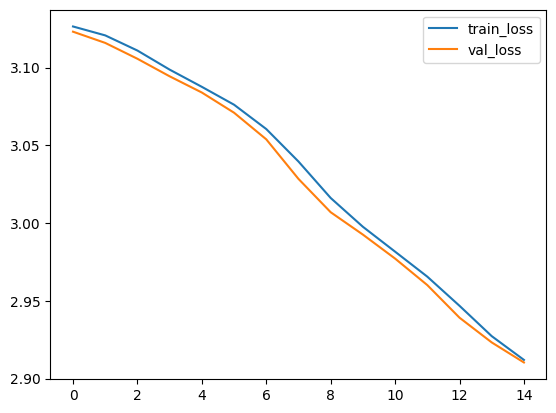

In [127]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

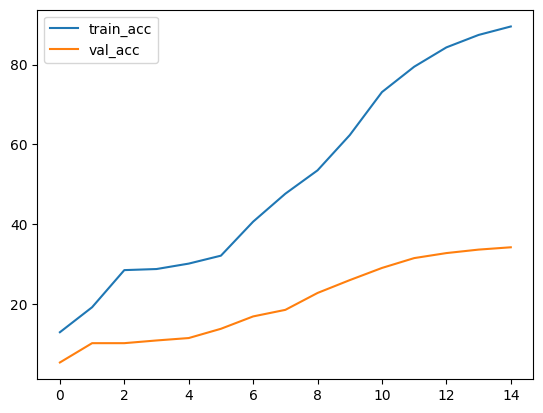

In [128]:
trn_acc_list = [t.to('cpu') for t in trn_acc_list]
val_acc_list = [t.to('cpu') for t in val_acc_list]
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [ ]:
# best_model = PlantDiseaseModel()
# best_model.load_state_dict(torch.load('best_model.pt'))


In [131]:
device

device(type='cuda')

In [132]:
corrects = 0
total = 0
best_model = PlantDiseaseModel(classes =23)
best_model.load_state_dict(torch.load('ShuffleNet3/best_model.pt'))
best_model = best_model.to(device)
best_model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(device), target.to(device)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

3375/11116 | test accuracy: 0.3036


In [134]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
best_model = PlantDiseaseModel(classes =23)
best_model.load_state_dict(torch.load('ShuffleNet3/best_model.pt'))
best_model = best_model.to(device)
# Set the model to evaluation mode
best_model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in dataloaders['test']:
    images, labels = images.to(device), labels.to(device)
    # Predict the labels
    outputs = best_model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))
print('Confusion matrix:\n', conf_matrix)

Precision: 0.1276, Recall: 0.2926, F-score: 0.1679
Confusion matrix:
 [[  0 129   0   0   0   0   0   0   0  86   1   0  62   0   0   9   0   0
    0 239   0   0   0]
 [  0 498   0   0   0   0   0   0   0   0   0   0   4   0   0   1   0   3
    0  14   0   0   0]
 [  0   5   0   0   0   0   0   0   0 112   8   0 156   0   0  67   0  75
    0  21   0   0   0]
 [  0   4   0   0   0   0   0   0   0 148   8   0 169   0   0   2   0  11
    0 187   0   0   0]
 [  0  29   0   0   0   0   0   0   0  16   0   0 212   0   0   0   0  48
    0 171   0   0   0]
 [  0  10   0   0   0   0   0   0   0 225  14   0  69   0   0  77   0  13
    0  22   0   0   0]
 [  0  54   0   0   0   0   0   0   0  18  22   0  60   0   0   7   0   0
    0 313   0   0   0]
 [  0   0   0   0   0   0   0   0   0 290   4   0  68   0   0   5   0   5
    0  91   0   0   0]
 [  0   1   0   0   0   0   0   0   0 174   8   0 240   0   0   2   0   3
    0  90   0   0   0]
 [  0   0   0   0   0   0   0   0   0 493   5   0   3   0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


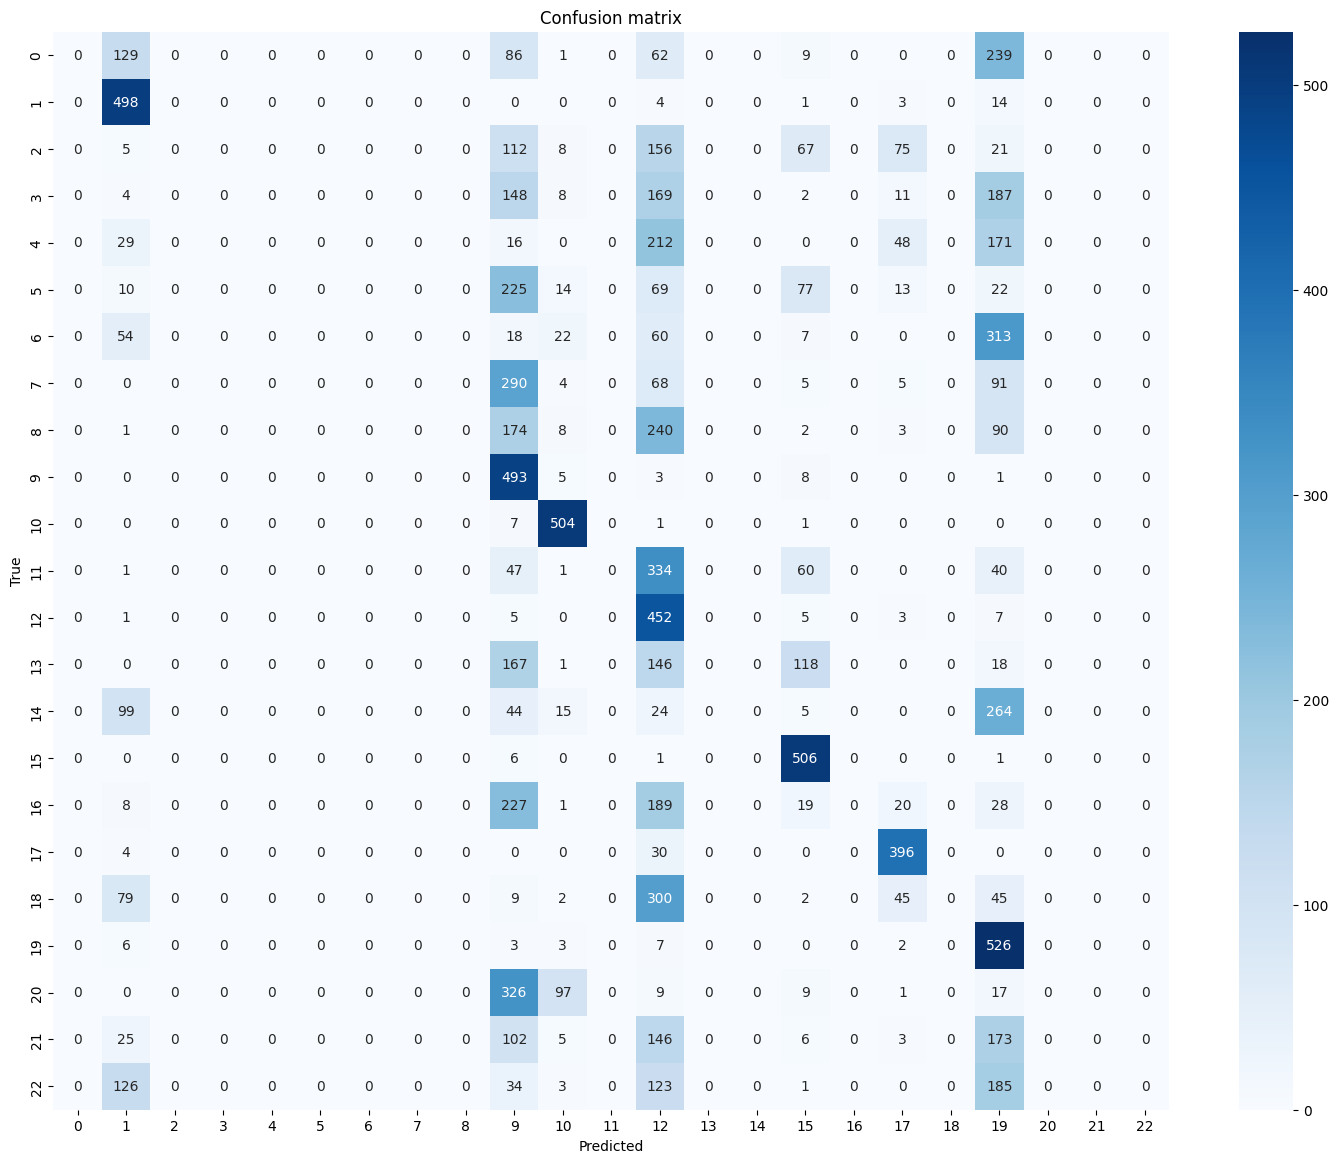

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
